In [ ]:
import pandas as pd
import numpy as np
import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio
import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization,Activation
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint


In [ ]:
Features = pd.read_csv("/content/drive/MyDrive/data_features_csvv/features_sdp.csv")
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.102905,0.513147,0.513315,0.516511,0.468581,0.541472,0.564084,0.557694,0.575990,0.562092,...,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,1.614189e-06,8.210545e-07,neutral
1,0.181858,0.574598,0.582838,0.588601,0.555525,0.621472,0.609586,0.593586,0.613791,0.611856,...,0.010592,0.010267,0.010016,0.010430,0.010306,0.010227,0.010388,1.049146e-02,1.059142e-02,neutral
2,0.102905,0.513147,0.513315,0.516511,0.468581,0.541472,0.564084,0.557694,0.575990,0.562092,...,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,1.614189e-06,8.210545e-07,neutral
3,0.079753,0.567420,0.466442,0.428961,0.487695,0.596271,0.518453,0.464962,0.628951,0.566925,...,0.000002,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,7.916440e-07,1.407018e-07,neutral
4,0.254444,0.735476,0.667130,0.640341,0.682895,0.742089,0.636692,0.590794,0.702980,0.685140,...,0.026518,0.026350,0.027469,0.026906,0.026571,0.027388,0.027411,2.770416e-02,2.738996e-02,neutral


In [ ]:
# Extract the emotions column
emotions = Features['labels']

# Find the count of each emotion
count = emotions.value_counts()

# Print the count of each emotion
print(count)

labels
neutral      7350
angry        4587
happy        2652
sad          2502
surprised    2247
fear         1779
Name: count, dtype: int64


In [ ]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [ ]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [ ]:
# splitting data, 80% train and 20 % test
x_train, x_test, y_train, y_test = train_test_split(X, Y,test_size=0.2, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((16893, 162), (16893, 6), (4224, 162), (4224, 6))

In [ ]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((16893, 162), (16893, 6), (4224, 162), (4224, 6))

In [ ]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((16893, 162, 1), (16893, 6), (4224, 162, 1), (4224, 6))

In [ ]:
model = Sequential()

model.add(Conv1D(128, 5, activation='relu', input_shape=(x_train.shape[1],1), padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2, padding='same'))
model.add(Dropout(0.2))

model.add(Conv1D(256, 5, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2, padding='same'))
model.add(Dropout(0.3))

model.add(Conv1D(512, 5, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2, padding='same'))
model.add(Dropout(0.4))

model.add(Conv1D(1024, 5, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2, padding='same'))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(y_train.shape[1], activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 162, 128)          768       
                                                                 
 batch_normalization (Batch  (None, 162, 128)          512       
 Normalization)                                                  
                                                                 
 max_pooling1d (MaxPooling1  (None, 81, 128)           0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 81, 128)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 81, 256)           164096    
                                                                 
 batch_normalization_1 (Bat  (None, 81, 256)           1

In [ ]:
#here we took 20% validation split from train data
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.8, verbose=2, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=80, validation_split=0.2, callbacks=[rlrp]) # 80 epochs

Epoch 1/80
212/212 [==============================] - 41s 35ms/step - loss: 1.7713 - accuracy: 0.3499 - val_loss: 1.6329 - val_accuracy: 0.3791 - lr: 0.0010
Epoch 2/80
212/212 [==============================] - 6s 27ms/step - loss: 1.5070 - accuracy: 0.4378 - val_loss: 1.4700 - val_accuracy: 0.4321 - lr: 0.0010
Epoch 3/80
212/212 [==============================] - 6s 28ms/step - loss: 1.4167 - accuracy: 0.4683 - val_loss: 1.3641 - val_accuracy: 0.4942 - lr: 0.0010
Epoch 4/80
212/212 [==============================] - 6s 28ms/step - loss: 1.3593 - accuracy: 0.4933 - val_loss: 1.2881 - val_accuracy: 0.5229 - lr: 0.0010
Epoch 5/80
212/212 [==============================] - 6s 30ms/step - loss: 1.3139 - accuracy: 0.5151 - val_loss: 1.2709 - val_accuracy: 0.5327 - lr: 0.0010
Epoch 6/80
212/212 [==============================] - 6s 28ms/step - loss: 1.2534 - accuracy: 0.5357 - val_loss: 1.3028 - val_accuracy: 0.4966 - lr: 0.0010
Epoch 7/80
212/212 [==============================] - 6s 29ms/s

In [ ]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")


132/132 [==============================] - 1s 5ms/step - loss: 0.4885 - accuracy: 0.9216
Accuracy of our model on test data :  92.16382503509521 %


In [ ]:
model.save('/content/drive/MyDrive/cnn_model(20%test).h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


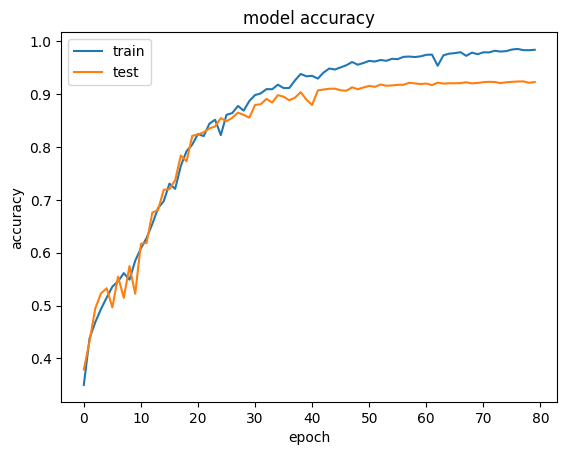

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

132/132 [==============================] - 1s 4ms/step


In [ ]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()
df.tail(10)

,Predicted Labels,Actual Labels
4214,neutral,neutral
4215,angry,neutral
4216,happy,happy
4217,angry,angry
4218,angry,neutral
4219,neutral,neutral
4220,angry,angry
4221,fear,fear
4222,angry,angry
4223,neutral,neutral


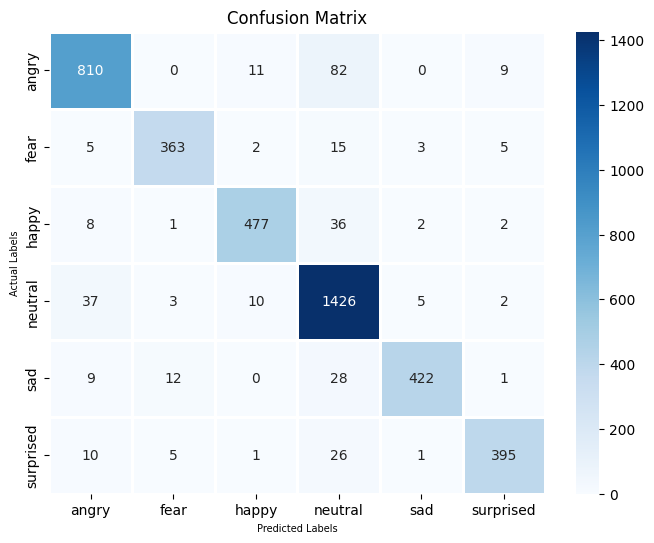

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (8, 6))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=12)
plt.xlabel('Predicted Labels', size=7)
plt.ylabel('Actual Labels', size=7)
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.92      0.89      0.90       912
        fear       0.95      0.92      0.93       393
       happy       0.95      0.91      0.93       526
     neutral       0.88      0.96      0.92      1483
         sad       0.97      0.89      0.93       472
   surprised       0.95      0.90      0.93       438

    accuracy                           0.92      4224
   macro avg       0.94      0.91      0.92      4224
weighted avg       0.92      0.92      0.92      4224



In [ ]:
# predicting on test data.
pred_train = model.predict(x_train)
y_train_pred = encoder.inverse_transform(pred_train)

y_train = encoder.inverse_transform(y_train)

528/528 [==============================] - 2s 4ms/step


In [ ]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

       angry       0.98      0.98      0.98      3675
        fear       0.99      0.99      0.99      1386
       happy       0.99      0.98      0.99      2126
     neutral       0.98      0.99      0.98      5867
         sad       0.99      0.98      0.99      2030
   surprised       0.99      0.98      0.99      1809

    accuracy                           0.98     16893
   macro avg       0.99      0.98      0.99     16893
weighted avg       0.98      0.98      0.98     16893



In [ ]:
from sklearn.metrics import accuracy_score
# calculate accuracy for each class
class_names = ["angry", "happy", "sad", "fear","surprised", "neutral"]
for i, class_name in enumerate(class_names):
    y_true_class = [1 if label == class_name else 0 for label in y_test]
    y_pred_class = [1 if label == class_name else 0 for label in y_pred]
    accuracy = accuracy_score(y_true_class, y_pred_class)
    print(f"Accuracy for {class_name} class: {accuracy}")

Accuracy for angry class: 0.9595170454545454
Accuracy for happy class: 0.982717803030303
Accuracy for sad class: 0.9855587121212122
Accuracy for fear class: 0.9879261363636364
Accuracy for surprised class: 0.9853219696969697
Accuracy for neutral class: 0.9422348484848485


In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import librosa
import librosa.display


from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

DURATION = 5
Features = pd.read_csv(r"/content/drive/MyDrive/data_features_csvv/features_sdp.csv")  # 24sdpnewversion
Features.head()
X = Features.iloc[:, :-1].values
Y = Features['labels'].values
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1, 1)).toarray()
# splitting data, 95% train and 5 % test
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0, shuffle=True)
# x_train.shape, y_train.shape, x_test.shape, y_test.shape
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
# x_train.shape, y_train.shape, x_test.shape, y_test.shape

# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
# x_train.shape, y_train.shape, x_test.shape, y_test.shape


sample_rate = 22500


def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result = np.hstack((result, zcr))  # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft))  # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc))  # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms))  # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel))  # stacking horizontally

    return result


fs = 22500
def predict_emotion():
    # Load the pre-trained CNN model
    loaded_model = tf.keras.models.load_model(
        r'/content/drive/MyDrive/cnn_model(20%test).h5')  # 24sdpnewversion
    # Load the recorded audio file
    audio, sr = librosa.load(r"/content/drive/MyDrive/angry.wav", sr=fs)

    # path_ = r"C:\Users\hp\Downloads\test_model\recording.wav"
    path_ = r"/content/drive/MyDrive/angry.wav"
    data_, sample_rate_ = librosa.load(path_)
    X_ = np.array(extract_features(data_))
    X_ = scaler.transform(X_.reshape(1, -1))
    pred_test_ = loaded_model.predict(np.expand_dims(X_, axis=2))
    prediction = encoder.inverse_transform(pred_test_)
    prediction = prediction[0][0]
    return prediction

print(predict_emotion())

1/1 [==============================] - 0s 234ms/step
happy
